## 라이브러리

In [1]:
import os
import random
import numpy as np
import torch
from glob import glob
import pandas as pd
from sklearn.model_selection import GroupKFold
import cv2 as cv
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data.sampler import SequentialSampler
from catalyst.data.sampler import BalanceClassSampler
from torch import nn
from torch import Tensor
import wandb
import shutil
import time
from torchvision import transforms
import torch.nn.functional as F
import torchvision.models as models
import sys

c:\Users\A10-E4\AppData\Local\Programs\Python\Python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 경로

In [2]:
DATA_PATH = 'dataset'
file_list = os.listdir(DATA_PATH)
print(file_list)

['dry', 'frozen', 'other', 'remove_frozen', 'remove_rain', 'rm.py', 'wet', 'win.py']


## 결과 재현을 위한 시드 설정, 디바이스 설정

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(43)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 전치리 과정 정의(폴드, 레이블 등록)

In [21]:
dataset = []
folder = ['dry', 'wet', 'frozen'] ##폴더 따라서 레이블링

for i in range(len(folder)):
    #'dry' = 0
    #'rain' = 1
    #'snow' = 2
    ##'other' = 3
    for path in glob(f'{DATA_PATH}/{folder[i]}/*.png', recursive=True):
        d = {
            'kind': folder[i],
            'image_name': path.replace('\\', '/').split('/')[-1],
            'label': i
        }
        dataset.append(d)
    
random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=5) # 5그룹으로 나누기
dataset['fold'] = 0 #폴드 컬럼 추가하기, 값은 0
'''
dataset 의 형상
kind | image_name         | label | fold
dry  | dataset/dry/D1.png | 0     | 0
 ' ' '


'''

#나눠진 폴드마다 학습/검증 다시 분할
groups = gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name']) # 5개 그룹

for fold_number, (train_index, val_index) in enumerate(groups):
    select_low_idx = dataset.iloc[val_index].index
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

In [6]:
dataset

,kind,image_name,label,fold
0,frozen,S2830_.png,2,0
1,wet,R3064.png,1,0
2,wet,R2673.png,1,3
3,wet,R3313.png,1,2
4,frozen,S2622_.png,2,1
...,...,...,...,...
3208,wet,R13.png,1,3
3209,frozen,S3343.png,2,4
3210,frozen,S2585.png,2,0
3211,wet,R2059.png,1,3


In [7]:
dataset['label'].value_counts()

1    2349
2     458
0     406
Name: label, dtype: int64

In [8]:
class DatasetRetriever(Dataset):
    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds # input dataset['kind']
        self.image_names = image_names # input dataset['image_name']
        self.labels = labels # input dataset['label']
        self.transforms = transforms #데이터 증대

    def __getitem__(self, index: int):
        kind = self.kinds[index]
        image_name = self.image_names[index]
        label = self.labels[index]

        image_path = f'{DATA_PATH}/{kind}/{image_name}'.replace('\\', '/')
        
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        scr = np.zeros([4, 2], dtype=np.float32)
        scr[0] = np.array([865, 38])#'left_top'
        scr[1] = np.array([1055 ,38])#'right_top'
        scr[2] = np.array([1165, 418])#'left_bottom'
        scr[3] = np.array([755, 418])#'right_bottom'
        dst = np.float32([[0, 0], [300, 0], [0, 300], [300, 300]])

        #퍼스펙티브 변환 행렬 생성
        m = cv.getPerspectiveTransform(scr, dst)

        #퍼스펙티브 변환,리사이즈 적용
        img_result = cv.warpPerspective(image, m, (300, 300))

        if self.transforms:
            sample = {'image': img_result}

            # https://dojang.io/mod/page/view.php?id=2347
            # 함수/또는 클래스의 인자명과 인자 수가 다르면 에러가 나도록 정의되어 있음에 유의
            sample = self.transforms(**sample)
            img_result = sample['image']
        return img_result, label

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

In [9]:
# import albumentations as A
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.5), #밝기 대비 무작위 조정, 50%확률
        A.Normalize(mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])),
        ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
        A.Normalize(mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])),
        ToTensorV2(p=1.0),
        ], p=1.0)

In [10]:
val_fold_value = 0  ## 0번 폴드를 검증용 폴드로 이용한다

train_dataset = DatasetRetriever(
    kinds = dataset[dataset['fold'] != val_fold_value].kind.values,
    image_names = dataset[dataset['fold'] != val_fold_value].image_name.values,
    labels = dataset[dataset['fold'] != val_fold_value].label.values,
    transforms = get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == val_fold_value].kind.values,
    image_names=dataset[dataset['fold'] == val_fold_value].image_name.values,
    labels=dataset[dataset['fold'] == val_fold_value].label.values,
    transforms=get_valid_transforms(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


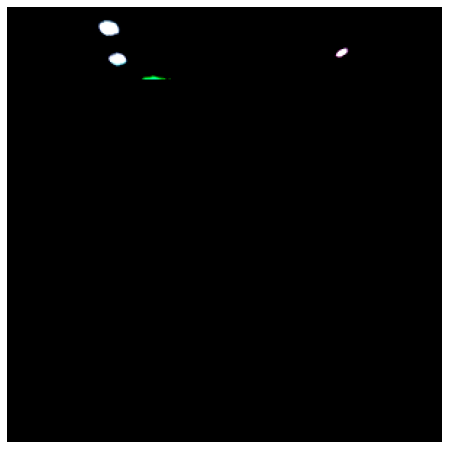

In [11]:
def print_img(one_data):
    import matplotlib.pyplot as plt
    image, target = one_data
    numpy_image = image.permute(1,2,0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    ax.set_axis_off()
    ax.imshow(numpy_image)


print_img(train_dataset[0])

In [12]:
batch_size = 32 ## 학습/검증 시 한번에 몇장의 이미지를 병렬연산 할 지 지정한다

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler = BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size = batch_size,
        pin_memory = False,
        drop_last = True,
    )

val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size = batch_size,
        shuffle = False,
        sampler = SequentialSampler(validation_dataset),
        pin_memory = False,
    )

## 정확도 측정

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, label, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = label.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # prediction: select k maximum at each output
    pred = pred.t()
    correct = pred.eq(label.view(1, -1).expand_as(pred))
    acc = correct.view(-1).float().sum(0, keepdim=True).mul_(100.0 / batch_size)  # acc = num of equivalcencs / target_size
    result = to_np(correct.view(-1))

    return acc, result

def to_np(x):
    return x.detach().cpu().data.numpy()


loss_func = nn.CrossEntropyLoss().to(device)

## 네트워크 정의

In [2]:
class A10E4_Net(nn.Module):
    def __init__(self) -> None:
      super(A10E4_Net, self).__init__()

      self.main = nn.Sequential(
          #group1 3채널 입력(컬러이미지), 특징 추출 유형1
          nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),
          
          #group2 특징 추출 유형1
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group3, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group4, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2), #flatten_size = 96 * (image_height//16) * (image_width//16)

        )

      self.fully_connected = nn.Sequential(               #group5 분류
            nn.Linear(in_features=384, out_features=384),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=384, out_features=192),
            nn.Dropout(p=0.2),
            nn.Linear(192, 192),
            nn.Dropout(p=0.2),
            nn.LogSoftmax(dim=1),
        )


    def forward(self, image: Tensor) -> Tensor:
        """Returns logit for the given tensor."""
        #with torch.no_grad():
            #out = ImagePreProcessing()(image)
        out = self.main(image)
        out = out.view(out.size(0), -1)
        out = self.fully_connected(out)
        return out

print("init model done")

init model done


## 학습에 필요한 동작 정의

In [15]:
def save_checkpoint(model, optimizer, best_acc, checkpoint_path, model_name, is_best, size, lr, epoch, seed_):
    name, param = model.named_parameters()
    state = {
        'python_v': sys.version,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'class_labels': folder,  # 예측할 클래스 레이블 정보
        'image_size': size,  # 이미지 크기
        'learning_rate': lr,  # 학습률
        'best_acc': best_acc,
        'epoch': epoch,
        'seed': seed_,
        'dtype': param.dtype
    }

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    filename = os.path.join(checkpoint_path, f'{model_name}_epoch_{state["epoch"]}.pth')
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, f'{model_name}_best.pth'))
        
        art = wandb.Artifact(f'model3_2_{model_name}', type="model")
        art.add_file(f'./checkpoints/{model_name}_best.pth')
        wandb.log_artifact(art)


def load_checkpoint(model, optimizer, pretrained_path, device):
    state = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state['model'])
    best_acc = state['best_acc']
    epoch = state['epoch']
    print(f'\t## loaded trained models (epoch: {epoch}).... init epoch(1) \n')
    epoch = 1 #init
    return model, optimizer, best_acc, epoch

In [16]:
def train(train_loader, model, *args):
    # switch to train mode
    model.train()

    with torch.enable_grad():
        train_acc, train_loss = iteration('train', train_loader, model, *args)

    return train_acc, train_loss

In [17]:
def validate(val_loader, model, *args):
    # switch to eval mode
    model.eval()

    with torch.no_grad():
        val_acc, val_loss = iteration('val', val_loader, model, *args)

    return val_acc, val_loss

In [18]:


def iteration(mode, data_loader, model, optimizer, loss_func, epoch, log_e, max_epoch):
    am_batch_time = AverageMeter()
    am_data_time = AverageMeter()
    am_loss = AverageMeter()
    am_acc = AverageMeter()

    end = time.time()
    num_batch = np.ceil(len(data_loader)).astype(np.int32)

    for i, (input_img, target) in enumerate(data_loader):
        # measure data loading time
        am_data_time.update(time.time() - end)
        input_img = input_img.to(device)
        target = target.to(device)
        
        # feed-forward
        output = model(input_img)   # two output
        
        # calculate loss
        output = torch.nan_to_num(output)
        loss = loss_func(output, target)
        am_loss.update(loss.item(), input_img.size(0))

        # calculate accuracy
        class_prob = F.softmax(output, dim=1)
        class_acc, _ = accuracy(class_prob, target)
        am_acc.update(class_acc.item(), input_img.size(0))

        # compute gradient and do SGD step
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        am_batch_time.update(time.time() - end)
        end = time.time()
        if (i + 1) % log_e == 0:
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})'
                  .format(epoch + 1, max_epoch, i + 1, num_batch, batch_time=am_batch_time,
                          data_time=am_data_time, loss=am_loss, acc=am_acc))

    return am_acc.avg, am_loss.avg

## TRAIN & VALIDATE

In [19]:
#2. Use that dataset to train a model
run = wandb.init(project="2023", job_type="model-training")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: a10e4. Use `wandb login --relogin` to force relogin


In [ ]:
args = {
    'model_name': 'A10E4_Net',  # 신경망 구조
    #'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 300,  # 이미지 크기
    'lr': 1e-3,
    'num_epochs': 500,  # 학습 반복수
    'num_classes': 3,  # 판별할 클래스 개수
    'log_step': 100,  # log 남길 iteration 반복 수
    'model_save_step': 20,  # model 저장할 epoch 반복 수
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'A10E4_Net_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
    'seed': 43
}

#model = get_net().to(device)
model = A10E4_Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=1e-4)


if args['pretrained_name']:
    pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
    #model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)
else:
    initial_epoch = 0
    best_acc = 0

initial_epoch = 0
best_acc = 0

min_loss = 1000
for epoch in range(initial_epoch, args['num_epochs']):
    # train for one epoch
    print('# Training')
    train_acc, train_loss = train(train_loader, model, optimizer, loss_func, epoch, args['log_step'], args['num_epochs'])
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss})
    print(f'epoch: {epoch}, train_acc: {train_acc}, train_loss: {train_loss}')

    # evaluate on validation set
    print('# Validation')
    val_acc, val_loss = validate(val_loader, model, optimizer, loss_func, epoch, args['log_step'], args['num_epochs'])
    wandb.log({'val_acc': val_acc, 'val_loss':val_loss})
    print(f'epoch: {epoch}, val_acc: {val_acc}, val_loss: {val_loss}')

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    min_loss = min(val_loss, min_loss)

    if is_best or (epoch + 1) % args['model_save_step'] == 0:
        save_checkpoint(model, optimizer, best_acc, args['checkpoint_dir'], args['model_name'], is_best, args['image_size'], args['lr'],epoch + 1, args['seed'])

In [ ]:
args = {
    'model_name': 'mobilenetv3_small',  # 신경망 구조
    #'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 300,  # 이미지 크기
    'lr': 1e-3,
    'num_epochs': 500,  # 학습 반복수
    'num_classes': 4,  # 판별할 클래스 개수
    'log_step': 100,  # log 남길 iteration 반복 수
    'model_save_step': 20,  # model 저장할 epoch 반복 수
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'mobilenetv3_small_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
    'seed': 43
}

model = models.mobilenet_v3_small(pretrained=True)
# 모델의 fully connected layer 수정 (출력 클래스 개수를 4로 변경)
model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=3)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay= 1e-4)


if args['pretrained_name']:
    pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
    #model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)
else:
    initial_epoch = 0
    best_acc = 0

initial_epoch = 0
best_acc = 0

min_loss = 1000
for epoch in range(initial_epoch, args['num_epochs']):
    # train for one epoch
    print('# Training')
    train_acc, train_loss = train(train_loader, model, optimizer, loss_func, epoch, args['log_step'], args['num_epochs'])
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss})
    print(f'epoch: {epoch}, train_acc: {train_acc}, train_loss: {train_loss}')

    # evaluate on validation set
    print('# Validation')
    val_acc, val_loss = validate(val_loader, model, optimizer, loss_func, epoch, args['log_step'], args['num_epochs'])
    wandb.log({'val_acc': val_acc, 'val_loss':val_loss})
    print(f'epoch: {epoch}, val_acc: {val_acc}, val_loss: {val_loss}')

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    min_loss = min(val_loss, min_loss)

    if is_best or (epoch + 1) % args['model_save_step'] == 0:
        save_checkpoint(model, optimizer, best_acc, args['checkpoint_dir'], args['model_name'], is_best, args['image_size'], args['lr'],epoch + 1, args['seed'])

## 모델 로드 후 사용하기

##     상단에 정의된 모델( A10E4_Net )

In [ ]:
class A10E4_Net(nn.Module):
    def __init__(self) -> None:
      super(A10E4_Net, self).__init__()

      self.main = nn.Sequential(
          #group1 3채널 입력(컬러이미지), 특징 추출 유형1
          nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),
          
          #group2 특징 추출 유형1
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group3, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group4, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2), #flatten_size = 96 * (image_height//16) * (image_width//16)

        )

      self.fully_connected = nn.Sequential(               #group5 분류
            nn.Linear(in_features=384, out_features=384),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=384, out_features=192),
            nn.Dropout(p=0.2),
            nn.Linear(192, 192),
            nn.Dropout(p=0.2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, image: Tensor) -> Tensor:
        """Returns logit for the given tensor."""
        #with torch.no_grad():
            #out = ImagePreProcessing()(image)
        out = self.main(image)
        out = out.view(out.size(0), -1)
        out = self.fully_connected(out)
        return out




# 정보 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_info = torch.load('checkpoints/A10E4_Net_epoch_63.pth', map_location=device)

'''
state = {
        'python_v': sys.version,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'class_labels': folder,  # 예측할 클래스 레이블 정보
        'image_size': size,  # 이미지 크기
        'learning_rate': lr,  # 학습률
        'best_acc': best_acc,
        'epoch': epoch,
        'seed': seed_,
        'dtype': param.dtype
    }


'''

# 예측할 클래스 레이블 정보, 이미지 크기
python_v = loaded_info['python_v']
class_labels = loaded_info['class_labels']
image_size = loaded_info['image_size']
seed = loaded_info['seed']
try:
    dtype = loaded_info['dtype']
except KeyError:
    dtype = torch.float32
torch.manual_seed(seed)
#print(python_v, class_labels, image_size, seed)


# 모델 생성
model = A10E4_Net()
model.load_state_dict(loaded_info['model'])


def pridect_f(path__):
    # 입력 데이터 생성
    #image = cv.imread('D:/AP/road/crop/test/dry/0051.png', cv.IMREAD_COLOR)
    image = cv.imread(path__, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    scr = np.zeros([4, 2], dtype=np.float32)
    scr[0] = np.array([865, 38])#'left_top'
    scr[1] = np.array([1055 ,38])#'right_top'
    scr[2] = np.array([1165, 418])#'left_bottom'
    scr[3] = np.array([755, 418])#'right_bottom'
    dst = np.float32([[0, 0], [300, 0], [0, 300], [300, 300]])

    #퍼스펙티브 변환 행렬 생성
    m = cv.getPerspectiveTransform(scr, dst)

    #퍼스펙티브 변환,리사이즈 적용
    img_result = cv.warpPerspective(image, m, (300, 300))


    #텐서 변환 정의
    transform_ = transforms.Compose([
        #transforms.Resize((300, 300)),  # 모델에 맞는 크기로 리사이징
        transforms.ToTensor(),      # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]) #정규화, 이미지넷 데이터셋 기준값
    ])

    input_tensor = transform_(img_result)
    input_tensor = input_tensor.unsqueeze(0)  # 데이터 형식 맞추기(배치 차원 추가)
    input_img = input_tensor.to(device)

    # 추론 실행
    model.eval()  # 모델을 추론 모드로 설정
    with torch.no_grad():
        outputs = model(input_img)

    probabilities = F.softmax(outputs, dim=1)
    rounded_probabilities = torch.round(probabilities * 1000) / 1000  # 소수점 아래 3자리까지 반올림

    # 가장 높은 확률과 해당 클래스 인덱스 찾기
    #max_probability, predicted_class = torch.max(probabilities, dim=1) # outputs.topk(k=1, dim=1, largest=True, sorted=True)
    max_probability, predicted_class = probabilities.topk(k=1, dim=1, largest=True, sorted=True)


    #print('모델 출력(처리x)', outputs)
    #print('모델 출력(처리o)', rounded_probabilities) # tensor([[1., 0., 0.]]) 형태 출력. dry는 0, water는 1, frozen은 2
    print(f'path :{path__}, 분류 : {predicted_class.item()}, 확률 : {max_probability.item()} ')
    return predicted_class.item()

files = os.listdir('D:/AP/surface/dataset/frozen')
res = []
for i in range(len(files)):
    a = pridect_f(f'D:/AP/surface/dataset/frozen/{files[i]}')
    res.append(a)

In [3]:
print(res.count(0))
print(res.count(1))
print(res.count(2))

0
0
458


##          mobilenetv3_small

In [ ]:
# 정보 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_info = torch.load('checkpoints/mobilenetv3_small_epoch_240.pth', map_location=device)

'''
state = {
        'python_v': sys.version,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'class_labels': folder,  # 예측할 클래스 레이블 정보
        'image_size': size,  # 이미지 크기
        'learning_rate': lr,  # 학습률
        'best_acc': best_acc,
        'epoch': epoch,
        'seed': seed_,
        'dtype': param.dtype
    }
'''

# 예측할 클래스 레이블 정보, 이미지 크기
python_v = loaded_info['python_v']
class_labels = loaded_info['class_labels']
image_size = loaded_info['image_size']
seed = loaded_info['seed']
try:
    dtype = loaded_info['dtype']
except KeyError:
    dtype = torch.float32
torch.manual_seed(seed)
print(python_v, class_labels, image_size, seed, dtype)


# 모델 생성
#모델이 모바일넷일 경우 이 문장 사용하여 모델 형상 맞춤
model = models.mobilenet_v3_small(pretrained=True)
# 모델의 fully connected layer 수정 (출력 클래스 개수를 4로 변경)
model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=3)
model.load_state_dict(loaded_info['model'])

def pridect_f(path__):
    # 입력 데이터 생성
    #image = cv.imread('D:/AP/road/crop/test/dry/0051.png', cv.IMREAD_COLOR)
    image = cv.imread(path__, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    scr = np.zeros([4, 2], dtype=np.float32)
    scr[0] = np.array([865, 38])#'left_top'
    scr[1] = np.array([1055 ,38])#'right_top'
    scr[2] = np.array([1165, 418])#'left_bottom'
    scr[3] = np.array([755, 418])#'right_bottom'
    dst = np.float32([[0, 0], [300, 0], [0, 300], [300, 300]])

    #퍼스펙티브 변환 행렬 생성
    m = cv.getPerspectiveTransform(scr, dst)

    #퍼스펙티브 변환,리사이즈 적용
    img_result = cv.warpPerspective(image, m, (300, 300))


    #텐서 변환 정의
    transform_ = transforms.Compose([
        #transforms.Resize((300, 300)),  # 모델에 맞는 크기로 리사이징
        transforms.ToTensor(),      # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]) #정규화, 이미지넷 데이터셋 기준값
    ])

    input_tensor = transform_(img_result)
    input_tensor = input_tensor.unsqueeze(0)  # 데이터 형식 맞추기(배치 차원 추가)
    input_img = input_tensor.to(device)

    # 추론 실행
    model.eval()  # 모델을 추론 모드로 설정
    with torch.no_grad():
        outputs = model(input_img)

    probabilities = F.softmax(outputs, dim=1)
    rounded_probabilities = torch.round(probabilities * 1000) / 1000  # 소수점 아래 3자리까지 반올림

    # 가장 높은 확률과 해당 클래스 인덱스 찾기
    #max_probability, predicted_class = torch.max(probabilities, dim=1) # outputs.topk(k=1, dim=1, largest=True, sorted=True)
    max_probability, predicted_class = probabilities.topk(k=1, dim=1, largest=True, sorted=True)


    #print('모델 출력(처리x)', outputs)
    #print('모델 출력(처리o)', rounded_probabilities) # tensor([[1., 0., 0.]]) 형태 출력. dry는 0, water는 1, frozen은 2
    print(f'path :{path__}, 분류 : {predicted_class.item()}, 확률 : {max_probability.item()} ')
    return predicted_class.item()

files = os.listdir('D:/AP/surface/dataset/dry')
res = []
for i in range(len(files)):
    a = pridect_f(f'D:/AP/surface/dataset/dry/{files[i]}')
    res.append(a)


In [9]:
print(res.count(0))
print(res.count(1))
print(res.count(2))

382
24
0


## 모델 파일 변환 .pth -> .onnx

In [4]:
def _to_onnx(model, n):
    # 입력 데이터의 예시 형태를 생성
    dummy_input = torch.randn(1, 3, 300, 300)  # (배치 크기, 채널 수, 높이, 너비)

    # ONNX로 변환
    onnx_filename = f'{n}.onnx' #변환 후 이름
    input_names = ['image'] #입력 이름(나중에 사용시 필요함.)
    torch.onnx.export(model, dummy_input, onnx_filename, input_names=input_names, opset_version=11)



def pth_to_onnx(path):
    # .pth 모델 정보 불러오기
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_info = torch.load(path, map_location=device)
    n = path.split('/')[-1]
    n = n.split('.')[0]

    # 예측할 클래스 레이블 정보, 이미지 크기
    python_v = loaded_info['python_v']
    class_labels = loaded_info['class_labels']
    image_size = loaded_info['image_size']
    seed = loaded_info['seed']
    torch.manual_seed(seed)
    print(python_v, class_labels, image_size, seed)

    if 'mobilenetv3_small' in path:
        model = models.mobilenet_v3_small(pretrained=True)
        # 모델의 fully connected layer 수정 (출력 클래스 개수를 4로 변경)
        model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=3)
        model.load_state_dict(loaded_info['model'])
        _to_onnx(model, n)
        
    elif 'A10E4_Net' in path:
        # 모델 생성/ 모델이 A10E4_Net() 일 경우
        model = A10E4_Net()
        model.load_state_dict(loaded_info['model'])
        _to_onnx(model, n)



model_name = 'checkpoints/A10E4_Net_epoch_63.pth'
pth_to_onnx(model_name)
model_name = 'checkpoints/mobilenetv3_small_epoch_240.pth'
pth_to_onnx(model_name)

3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)] ['dry', 'wet', 'frozen'] 300 43
3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)] ['dry', 'wet', 'frozen'] 300 43


## 모델 양자화(float32 -> int8)

In [65]:
import torch
from torch.quantization import quantize_dynamic

def model_quantize(path, type_):
    # .pth 모델 정보 불러오기
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_info = torch.load(path, map_location=device)
    n = path.split('/')[-1]
    n = n.split('.')[0]

    # 예측할 클래스 레이블 정보, 이미지 크기
    python_v = loaded_info['python_v']
    class_labels = loaded_info['class_labels']
    image_size = loaded_info['image_size']
    seed = loaded_info['seed']
    torch.manual_seed(seed)
    print(python_v, class_labels, image_size, seed)

    if 'mobilenetv3_small' in path:
        model = models.mobilenet_v3_small(pretrained=True)
        # 모델의 fully connected layer 수정 (출력 클래스 개수를 4로 변경)
        model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=3)
        model.load_state_dict(loaded_info['model'])
        
    elif 'A10E4_Net' in path:
        # 모델 생성/ 모델이 A10E4_Net() 일 경우
        model = A10E4_Net()
        model.load_state_dict(loaded_info['model'])
    
    quantized_model = quantize_dynamic(model, dtype=type_)
    name, param = list(quantized_model.named_parameters())[1]
    print(f'{param.dtype} -> {type_}')
    state = {
        'python_v': sys.version,
        'model': quantized_model.state_dict(),
        'class_labels': folder,  # 예측할 클래스 레이블 정보
        'image_size': 300,  # 이미지 크기
        'seed': 43,
        'dtype': type_
    }
    torch.save(state, f'{n}_qunt.pth')

    return model

In [66]:
model_name = 'checkpoints/A10E4_Net_epoch_63.pth'
mod = model_quantize(model_name, torch.qint8)
model_name = 'checkpoints/mobilenetv3_small_epoch_240.pth'
mod2 = model_quantize(model_name, torch.qint8)

3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)] ['dry', 'wet', 'frozen'] 300 43
torch.float32 -> torch.qint8
3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)] ['dry', 'wet', 'frozen'] 300 43
torch.float32 -> torch.qint8


## 양자화된 모델의 사용(mobilenetv3_small)

In [6]:
import torch
from torch.quantization import quantize_dynamic

# 정보 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_info = torch.load('mobilenetv3_small_epoch_240_qunt.pth', map_location=device)


'''
state = {
        'python_v': sys.version,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'class_labels': folder,  # 예측할 클래스 레이블 정보
        'image_size': size,  # 이미지 크기
        'learning_rate': lr,  # 학습률
        'best_acc': best_acc,
        'epoch': epoch,
        'seed': seed_,
        'dtype': param.dtype
    }
'''

# 예측할 클래스 레이블 정보, 이미지 크기
python_v = loaded_info['python_v']
class_labels = loaded_info['class_labels']
image_size = loaded_info['image_size']
seed = loaded_info['seed']
try:
    dtype = loaded_info['dtype']
except KeyError:
    dtype = torch.float32
torch.manual_seed(seed)
print(python_v, class_labels, image_size, seed, dtype)


# 모델 생성
#모델이 모바일넷일 경우 이 문장 사용하여 모델 형상 맞춤
model = models.mobilenet_v3_small(pretrained=True)
# 모델의 fully connected layer 수정 (출력 클래스 개수를 4로 변경)
model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=3)
if dtype != torch.float32:
    model = quantize_dynamic(model, dtype=dtype)
model.load_state_dict(loaded_info['model'])


def pridect_f(path__):
    image = cv.imread(path__, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    scr = np.zeros([4, 2], dtype=np.float32)
    scr[0] = np.array([865, 38])#'left_top'
    scr[1] = np.array([1055 ,38])#'right_top'
    scr[2] = np.array([1165, 418])#'left_bottom'
    scr[3] = np.array([755, 418])#'right_bottom'
    dst = np.float32([[0, 0], [300, 0], [0, 300], [300, 300]])

    #퍼스펙티브 변환 행렬 생성
    m = cv.getPerspectiveTransform(scr, dst)

    #퍼스펙티브 변환,리사이즈 적용
    img_result = cv.warpPerspective(image, m, (300, 300))


    #텐서 변환 정의
    transform_ = transforms.Compose([
        transforms.ToTensor(),      # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]) #정규화, 이미지넷 데이터셋 기준값
    ])

    input_tensor = transform_(img_result)
    input_tensor = input_tensor.unsqueeze(0)  # 데이터 형식 맞추기(배치 차원 추가)
    
    if dtype != torch.float32: # 가중치 양자화된 모델을 사용할 경우, QuantStub을 사용하여 데이터 변환
        quantize = torch.quantization.QuantStub()
        input_tensor = quantize(input_tensor)
    input_img = input_tensor.to(device)

    # 추론 실행
    model.eval()
    with torch.no_grad():
        outputs = model(input_img)

    probabilities = F.softmax(outputs, dim=1)
    rounded_probabilities = torch.round(probabilities * 1000) / 1000  # 소수점 아래 3자리까지 반올림
    max_probability, predicted_class = probabilities.topk(k=1, dim=1, largest=True, sorted=True)

    print(f'path :{path__}, 분류 : {predicted_class.item()}, 확률 : {max_probability.item()} ')
    return predicted_class.item()

files = os.listdir('D:/AP/surface/dataset/dry')
res = []
for i in range(len(files)):
    a = pridect_f(f'D:/AP/surface/dataset/dry/{files[i]}')
    res.append(a)


3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)] ['dry', 'wet', 'frozen'] 300 43 torch.qint8
path :D:/AP/surface/dataset/dry/D12028.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12028_.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12029.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12029_.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12030.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12030_.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12031.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12031_.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12032.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12032_.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12033.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12033_.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12034.png, 분류 : 0, 확률 : 1.0 
path :D:/AP/surface/dataset/dry/D12034_.png, 분류 : 0, 확률 : 1.0 

## 양자화된 모델의 사용(A10E4_Net)

In [8]:
import torch
from torch.quantization import quantize_dynamic

class A10E4_Net(nn.Module):
    def __init__(self) -> None:
      super(A10E4_Net, self).__init__()

      self.main = nn.Sequential(
          #group1 3채널 입력(컬러이미지), 특징 추출 유형1
          nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),
          
          #group2 특징 추출 유형1
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group3, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group4, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2), #flatten_size = 96 * (image_height//16) * (image_width//16)

        )

      self.fully_connected = nn.Sequential(               #group5 분류
            nn.Linear(in_features=384, out_features=384),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=384, out_features=192),
            nn.Dropout(p=0.2),
            nn.Linear(192, 192),
            nn.Dropout(p=0.2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, image: Tensor) -> Tensor:
        """Returns logit for the given tensor."""
        #with torch.no_grad():
            #out = ImagePreProcessing()(image)
        out = self.main(image)
        out = out.view(out.size(0), -1)
        out = self.fully_connected(out)
        return out




# 정보 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_info = torch.load('A10E4_Net_epoch_63_qunt.pth', map_location=device)

'''
state = {
        'python_v': sys.version,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'class_labels': folder,  # 예측할 클래스 레이블 정보
        'image_size': size,  # 이미지 크기
        'learning_rate': lr,  # 학습률
        'best_acc': best_acc,
        'epoch': epoch,
        'seed': seed_,
        'dtype': param.dtype
    }


'''

# 예측할 클래스 레이블 정보, 이미지 크기
python_v = loaded_info['python_v']
class_labels = loaded_info['class_labels']
image_size = loaded_info['image_size']
seed = loaded_info['seed']
try:
    dtype = loaded_info['dtype']
except KeyError:
    dtype = torch.float32
torch.manual_seed(seed)
print(python_v, class_labels, image_size, seed, dtype)


# 모델 생성
model = A10E4_Net()
if dtype != torch.float32:
    model = quantize_dynamic(model, dtype=dtype)
model.load_state_dict(loaded_info['model'])


def pridect_f(path__):
    image = cv.imread(path__, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    scr = np.zeros([4, 2], dtype=np.float32)
    scr[0] = np.array([865, 38])#'left_top'
    scr[1] = np.array([1055 ,38])#'right_top'
    scr[2] = np.array([1165, 418])#'left_bottom'
    scr[3] = np.array([755, 418])#'right_bottom'
    dst = np.float32([[0, 0], [300, 0], [0, 300], [300, 300]])

    #퍼스펙티브 변환 행렬 생성
    m = cv.getPerspectiveTransform(scr, dst)

    #퍼스펙티브 변환,리사이즈 적용
    img_result = cv.warpPerspective(image, m, (300, 300))


    #텐서 변환 정의
    transform_ = transforms.Compose([
        transforms.ToTensor(),      # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]) #정규화, 이미지넷 데이터셋 기준값
    ])

    input_tensor = transform_(img_result)
    input_tensor = input_tensor.unsqueeze(0)  # 데이터 형식 맞추기(배치 차원 추가)
    
    if dtype != torch.float32: # 가중치 양자화된 모델을 사용할 경우, QuantStub을 사용하여 데이터 변환
        quantize = torch.quantization.QuantStub()
        input_tensor = quantize(input_tensor)
    input_img = input_tensor.to(device)

    # 추론 실행
    model.eval()
    with torch.no_grad():
        outputs = model(input_img)

    probabilities = F.softmax(outputs, dim=1)
    rounded_probabilities = torch.round(probabilities * 1000) / 1000  # 소수점 아래 3자리까지 반올림
    max_probability, predicted_class = probabilities.topk(k=1, dim=1, largest=True, sorted=True)

    print(f'path :{path__}, 분류 : {predicted_class.item()}, 확률 : {max_probability.item()} ')
    return predicted_class.item()

files = os.listdir('D:/AP/surface/dataset/frozen')
res = []
for i in range(len(files)):
    a = pridect_f(f'D:/AP/surface/dataset/frozen/{files[i]}')
    res.append(a)

3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)] ['dry', 'wet', 'frozen'] 300 43 torch.qint8
path :D:/AP/surface/dataset/frozen/S10928.png, 분류 : 2, 확률 : 0.8741585612297058 
path :D:/AP/surface/dataset/frozen/S10928_.png, 분류 : 2, 확률 : 0.7850669622421265 
path :D:/AP/surface/dataset/frozen/S10993.png, 분류 : 2, 확률 : 0.999576985836029 
path :D:/AP/surface/dataset/frozen/S10993_.png, 분류 : 2, 확률 : 0.9995459914207458 
path :D:/AP/surface/dataset/frozen/S10994.png, 분류 : 2, 확률 : 0.9995195865631104 
path :D:/AP/surface/dataset/frozen/S10994_.png, 분류 : 2, 확률 : 0.9994863271713257 
path :D:/AP/surface/dataset/frozen/S10995.png, 분류 : 2, 확률 : 0.9995971322059631 
path :D:/AP/surface/dataset/frozen/S10995_.png, 분류 : 2, 확률 : 0.9995759129524231 
path :D:/AP/surface/dataset/frozen/S10996.png, 분류 : 2, 확률 : 0.9995867609977722 
path :D:/AP/surface/dataset/frozen/S10996_.png, 분류 : 2, 확률 : 0.9995631575584412 
path :D:/AP/surface/dataset/frozen/S10997.png, 분류 : 2, 확률 : 0.99947386